# <center> We are the DaDTeam! </center>
<center> Balazs Fodor, Hodvogner Szilvia, Gergely Dobreff </center>

## Goal
We choose topic NLP2 (ChatBot based on deep learning) for the Deep Learning Course's homework. Our goal is to build a Neural Network for the [SMCalFlow challenge](https://microsoft.github.io/task_oriented_dialogue_as_dataflow_synthesis/). This competition was announced by Microsoft Semantic Machine, the motivation for this competition is that one of the central challenges in conversational AI is the design of a dialogue state representation that agents can use to reason about the information and actions available to them. They have developed a new representational framework for dialogue that enables efficient machine learning of complex conversations.

## Dataset
SMCalFlow is a large English-language dialogue dataset, featuring natural conversations about tasks involving calendars, weather, places, and people. It has 41,517 conversations annotated with dataflow programs. In contrast to existing dialogue datasets, this dialogue collection was not based on pre-specified scripts, and participants were not restricted in terms of what they could ask for and how they should accomplish their tasks. As a result, SMCalFlow is qualitatively different from existing dialogue datasets, featuring explicit discussion about agent capabilities, multi-turn error recovery, and complex goals.

## Reference
The original scientific paper about the framework, the dataset and their baseline solution can be found [here](https://www.mitpressjournals.org/doi/10.1162/tacl_a_00333), a shorter summary in the form of a blog post can be found [at this link](https://www.microsoft.com/en-us/research/blog/dialogue-as-dataflow-a-new-approach-to-conversational-ai/). 

Microsoft also opensourced a [github repository](https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis) containing codes to reproduce their results in the article. The library can be installed with pip using the following command:
```sh
pip install git+https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git
```

---

In the following, we present this dataset and our preliminary solution proposals.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import json
import pprint

In [2]:
# import or install and import the github library related to the original article
try:
    from dataflow.core import lispress
except ImportError as error:
    !pip install git+https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git
    print(error)
    from dataflow.core import lispress

Download dataset and extract it

In [ ]:
!mkdir data
!wget -c https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz -O - | tar -xz -C data

--2020-10-24 10:02:30--  https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz
Resolving smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)... 52.191.176.36
Connecting to smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13703288 (13M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  13.07M  6.66MB/s    in 2.0s    

2020-10-24 10:02:32 (6.66 MB/s) - written to stdout [13703288/13703288]



## Dataset analysis and preparation

In [3]:
# wrapper class for displaying the conversations in the dataset
class ConvWrapper:
    def __init__(self,data):
        self.data = data

    def show_conv(self,showProgram=False):
        for turn in self.data['turns']:
            print('User> ',turn['user_utterance']['original_text'])
            if(showProgram):
                LisPress = lispress.parse_lispress(turn['lispress'])
                print('PROGRAM: ')
                print(lispress.render_pretty(LisPress))
            print('Agent> ',turn['agent_utterance']['original_text'])
    def print(self):
        pprint.pprint(self.data)
    

In [4]:
# load train dataset
train = []
with open("data/train.dataflow_dialogues.jsonl") as trainfile:
    content = trainfile.read()
    train = [json.loads(line) for line in content.splitlines()]

In [5]:
# display the first training conversation
example = ConvWrapper(train[0])
example.show_conv()

User>  what date is tomorrow?
Agent>  Tomorrow's date is February 5, 2019.
User>  What day of the week is tomorrow?
Agent>  Tomorrow is Wednesday.
User>  please help me
Agent>  I can help you create, update, and delete events on your calendar. You can also ask me about your schedule.


In [6]:
# display the first two training conversations with the corresponding lispress programs (the inner representation of the dialogue state) at each turn
example = ConvWrapper(train[0])
example.show_conv(True)
print('\n-----------------------------------------------------------------------------------\n')
example = ConvWrapper(train[1])
example.show_conv(True)

User>  what date is tomorrow?
PROGRAM: 
(Yield :output (Tomorrow))
Agent>  Tomorrow's date is February 5, 2019.
User>  What day of the week is tomorrow?
PROGRAM: 
(Yield :output (:dayOfWeek (Tomorrow)))
Agent>  Tomorrow is Wednesday.
User>  please help me
PROGRAM: 
(PleasantryCalendar)
Agent>  I can help you create, update, and delete events on your calendar. You can also ask me about your schedule.

-----------------------------------------------------------------------------------

User>  What time is my appointment with Jerri Skinner on Friday?
PROGRAM: 
(Yield
  :output (:start
    (singleton
      (:results
        (FindEventWrapperWithDefaults
          :constraint (EventOnDate
            :date (NextDOW :dow #(DayOfWeek "FRIDAY"))
            :event (Constraint[Event]
              :attendees (AttendeeListHasRecipientConstraint
                :recipientConstraint (RecipientWithNameLike
                  :constraint (Constraint[Recipient])
                  :name #(PersonName "J

In [7]:
# display one training data with all fields:
example = ConvWrapper(train[0])
example.print()

{'dialogue_id': '8c112de4-0c61-43b1-b437-8e176fed39b6',
 'turns': [{'agent_utterance': {'described_entities': [],
                                'original_text': "Tomorrow's date is February "
                                                 '5, 2019.',
                                'tokens': ['Tomorrow',
                                           "'s",
                                           'date',
                                           'is',
                                           'February',
                                           '5',
                                           ',',
                                           '2019',
                                           '.']},
            'lispress': '(Yield :output (Tomorrow))',
            'program_execution_oracle': {'has_exception': False,
                                         'refer_are_correct': True},
            'skip': True,
            'turn_index': 0,
            'user_utterance': {'original_text'

The training data contains an id and the turns of the dialogue, each turn consists the user message, and the agent response, with the following important meta information:


*   tokens and original text for both the user message and the agent response
*   turn_index: the sequence number of that turn
*   lispress
    * the program that stores the inner state of the conversation
    * the agent should generate a response based on this

---



In [8]:
# load validation data
valid = []
with open("data/valid.dataflow_dialogues.jsonl") as validfile:
    content = validfile.read()
    valid = [json.loads(line) for line in content.splitlines()]

In [9]:
# print an example
valid_example = ConvWrapper(valid[0])
valid_example.print()

{'dialogue_id': 'f40ad346-9cb4-46a2-8d6d-13926371cffd',
 'turns': [{'agent_utterance': {'described_entities': ['entity@1135690515'],
                                'original_text': 'Is this good?',
                                'tokens': ['Is', 'this', 'good', '?']},
            'lispress': '(Yield :output (CreateCommitEventWrapper :event '
                        '(CreatePreflightEventWrapper :constraint '
                        '(Constraint[Event] :attendees (andConstraint '
                        '(AttendeeListHasRecipient :recipient (Execute '
                        ':intension (refer (extensionConstraint '
                        '(RecipientWithNameLike :constraint '
                        '(Constraint[Recipient]) :name #(PersonName '
                        '"Jeff")))))) (AttendeeListHasRecipient :recipient '
                        '(Execute :intension (refer (extensionConstraint '
                        '(RecipientWithNameLike :constraint '
                        '(Con

The validation data consists the same structure of dialogues

### Tokenize texts
Although the train and validation data are tokenized (contain a field with the tokens), but the tokens are not converted to lowercase and special characters are also included, so further data cleaning is necessary

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
# create a tokenizer and fit on the sentences of the train data dialogues
tokenizer = Tokenizer()
dialogue_sent = [turn['user_utterance']['original_text'] for dialog in train for turn in dialog['turns'] ]
tokenizer.fit_on_texts(dialogue_sent)
# index of "the"
tokenizer.word_index["the"]

1

In [12]:
# example: tokens of the first two sentences
[[tokenizer.index_word[code] for code in seq] for seq in tokenizer.texts_to_sequences(dialogue_sent[:2]) ]

[['what', 'date', 'is', 'tomorrow'],
 ['what', 'day', 'of', 'the', 'week', 'is', 'tomorrow']]

In [13]:
def tokenizeDialogues(dataset,tokenizer):
    """
    Add a tokens2 attribute to the user_utterance in each turn with the token indexes
    Add a tokens2_readable attribute to the user_utterance with the readable tokens
    """
    for dialog in dataset:
        for turn in dialog['turns']:
            seq = tokenizer.texts_to_sequences([turn["user_utterance"]["original_text"]])[0]
            turn["user_utterance"].update({"tokens2":seq,"tokens2_readable":[tokenizer.index_word[index] for index in seq]})
    tokenizedSet = [[ turn['user_utterance']['tokens2'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenizedSet,dataset

In [14]:
train_tokenized,train = tokenizeDialogues(train,tokenizer=tokenizer)
valid_tokenized,valid = tokenizeDialogues(valid,tokenizer=tokenizer)

In [15]:
# example: tokens generated from a message
print("message:",train[0]["turns"][0]["user_utterance"]["original_text"])
print("tokens:",train[0]["turns"][0]["user_utterance"]["tokens2"])
print("readable tokens:",train[0]["turns"][0]["user_utterance"]["tokens2_readable"])

message: what date is tomorrow?
tokens: [18, 101, 12, 22]
readable tokens: ['what', 'date', 'is', 'tomorrow']


In [16]:
def flatten_nested_list(list0):
    """
    Flatten the nested list's elements
    Example:
    [[1,2],[3]] => [1,2,3]
    """
    return [element for nested in list0 for element in nested ]

In [17]:
# part of the train data converted to fix sized vectors
example_train_data = tokenizer.sequences_to_matrix(flatten_nested_list(train_tokenized)[:10])
# vectors with 16297 elements
example_train_data.shape

(10, 16297)

In [18]:
# size of the dictiorary:
print("size of the dictionary:",len(tokenizer.index_word))

size of the dictionary: 16296


## Data analysis

In [19]:
def calculate_freq_list(item_list):
    """
    Calculate item frequencies in the given list
    """
    freq_list = {}
    for item in item_list:
        if item in freq_list:
            freq_list[item] += 1
        else:
            freq_list[item] = 1

    sorted_freq_list = {k: v for k, v in sorted(freq_list.items(), key=lambda item: item[1], reverse=True)}
    return sorted_freq_list

In [20]:
def calculate_ngrams_and_freq(tokenized_dataset, ngram_size):
    """
    Create the list of all ngrams, n is given as parameter called ngram_size
    Calculate the frequencies of the ngrams
    """
    token_sequences_ngrams = flatten_nested_list([tf.strings.ngrams(seq, ngram_size).numpy() for seq in tokenized_dataset])
    token_sequences_ngrams = [x.decode('utf-8') for x in token_sequences_ngrams]    
    sorted_ngram_freq = calculate_freq_list(token_sequences_ngrams)
    return token_sequences_ngrams, sorted_ngram_freq

### User utterances

<AxesSubplot:title={'center':'Most frequent user utterances'}>

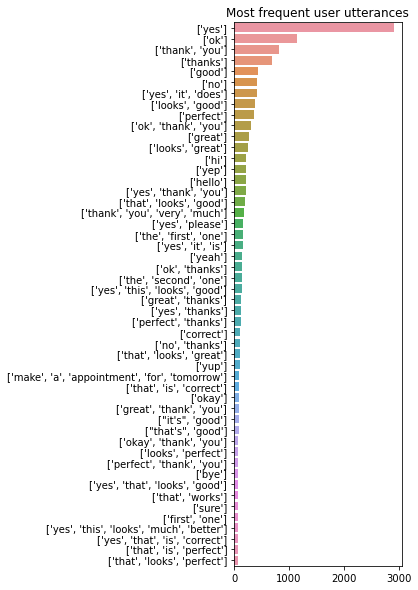

In [33]:
user_utteraces = [str(turn['user_utterance']['tokens2_readable']) for dialog in train for turn in dialog['turns']]
user_utt_freq = calculate_freq_list(user_utteraces)

plt.figure(figsize=(3,10))
plt.title("Most frequent user utterances")
sns.barplot(x=list(user_utt_freq.values())[:50], y=list(user_utt_freq.keys())[:50], orient="h")

<AxesSubplot:title={'center':'Most frequent words by users'}>

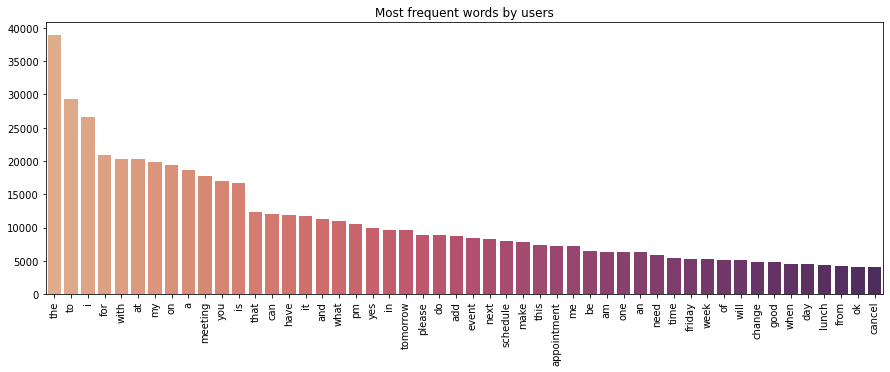

In [22]:
x = [key for key in list(tokenizer.index_word.values())[:50]]
y = [tokenizer.word_counts[key] for key in x]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words by users")
sns.barplot(x=x, y=y, palette="flare")

In [23]:
token_sequences = [turn['user_utterance']['tokens2_readable'] for dialog in train for turn in dialog['turns']]
token_sequences_ngrams, sorted_ngram_freq = calculate_ngrams_and_freq(token_sequences, 2)
print("Number of unique bigrams:", len(sorted_ngram_freq))

Number of unique bigrams: 118158


<AxesSubplot:title={'center':'Most frequent bigrams by users'}>

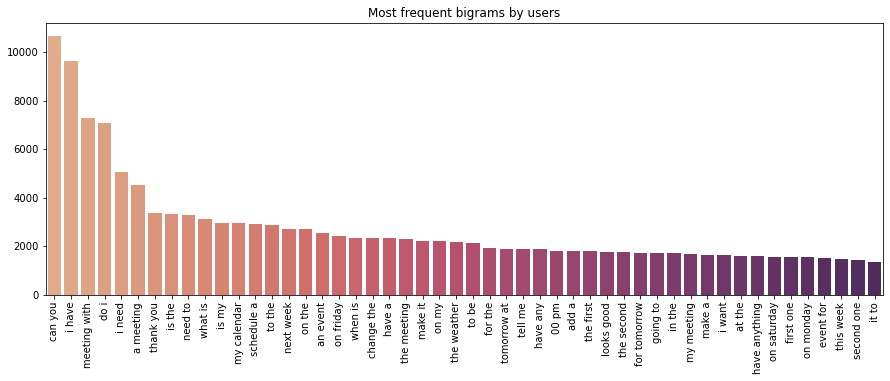

In [24]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent bigrams by users")
sns.barplot(x=list(sorted_ngram_freq.keys())[:50], y = list(sorted_ngram_freq.values())[:50], palette="flare")

In [25]:
token_sequences_ngrams, sorted_ngram_freq = calculate_ngrams_and_freq(token_sequences, 3)
print("Number of unique 3grams:", len(sorted_ngram_freq))

Number of unique 3grams: 272096


<AxesSubplot:title={'center':'Most frequent 3grams by users'}>

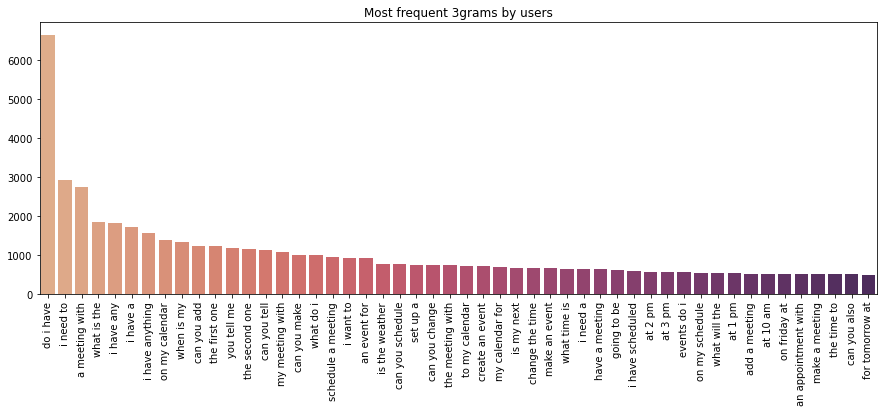

In [26]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent 3grams by users")
sns.barplot(x=list(sorted_ngram_freq.keys())[:50], y = list(sorted_ngram_freq.values())[:50], palette="flare")

### Agent utterances

In [27]:
dialogue_agent = [turn['agent_utterance']['original_text'] for dialog in train for turn in dialog['turns']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dialogue_agent)

<AxesSubplot:title={'center':'Most frequent words by the agent'}>

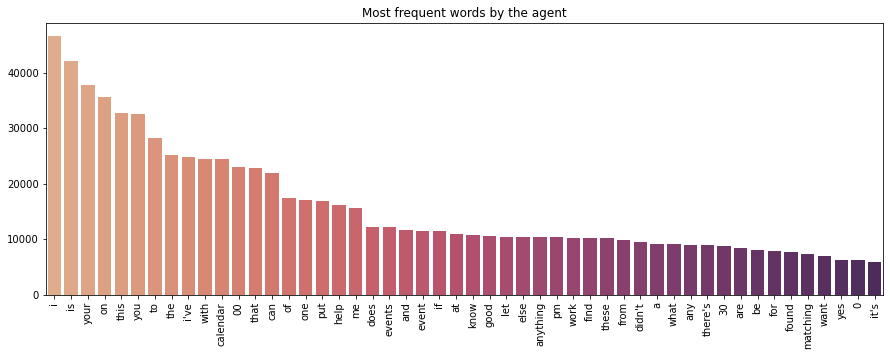

In [28]:
x = [key for key in list(tokenizer.index_word.values())[:50]]
y = [tokenizer.word_counts[key] for key in x]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words by the agent")
sns.barplot(x=x, y=y, palette="flare")

<AxesSubplot:title={'center':'Most frequent agent utterances'}>

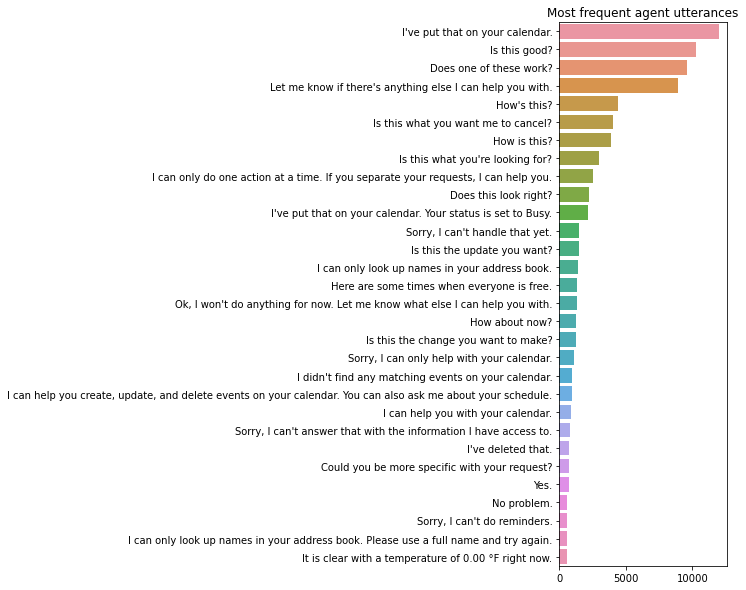

In [31]:
sorted_ans_freq = calculate_freq_list(dialogue_agent)

plt.figure(figsize=(3,10))
plt.title("Most frequent agent utterances")
sns.barplot(x=list(sorted_ans_freq.values())[:30], y=list(sorted_ans_freq.keys())[:30], orient="h")

### Code

In [30]:
codes = [turn['lispress'] for dialog in train for turn in dialog['turns']]
sorted_code_freq = calculate_freq_list(codes)
code_lengths = [len(code) for code in sorted_code_freq.keys()]
print("Avarage code length (chars):", np.mean(code_lengths))

Avarage code length (chars): 320.96267822670774


In [51]:
key_list = list(sorted_code_freq.keys())
value_list = list(sorted_code_freq.values())
for i in range(20):
    print("Frequency:", value_list[i])
    print("Code:")
    print(key_list[i])
    print()

Frequency: 14256
Code:
(Yield :output (Execute :intension (ConfirmAndReturnAction)))

Frequency: 8888
Code:
(PleasantryAnythingElseCombined)

Frequency: 2471
Code:
(FenceMultiAction)

Frequency: 1955
Code:
(FenceAttendee)

Frequency: 1735
Code:
(Yield :output (Execute :intension (ChooseCreateEvent :index #(Number 2) :intension (refer (ActionIntensionConstraint)))))

Frequency: 1486
Code:
(Yield :output (Execute :intension (ChooseCreateEvent :index #(Number 1) :intension (refer (ActionIntensionConstraint)))))

Frequency: 1478
Code:
(FenceOther)

Frequency: 1340
Code:
(DoNotConfirm)

Frequency: 1102
Code:
(FenceScope)

Frequency: 911
Code:
(PleasantryCalendar)

Frequency: 897
Code:
(Yield :output (Execute :intension (ChooseCreateEventFromConstraint :constraint (Constraint[Event]) :intension (refer (ActionIntensionConstraint)))))

Frequency: 833
Code:
(GenericPleasantry)

Frequency: 775
Code:
(Yield :output (DeleteCommitEventWrapper :event (DeletePreflightEventWrapper :id (:id (Execute :i

## Examples


In [45]:
from dataflow.analysis import compute_data_statistics

### Basic statistics

In [46]:
compute_data_statistics.main("data", ['train', 'valid'], "output")

Reading <class 'dataflow.core.dialogue.Dialogue'> from data\train.dataflow_dialogues.jsonl: 32647 dialogues [01:00, 539.85 dialogues/s]
Reading <class 'dataflow.core.dialogue.Dialogue'> from data\valid.dataflow_dialogues.jsonl: 3649 dialogues [00:07, 492.38 dialogues/s]


In [47]:
# print basic statistics about the full dataset
with open('output/train-valid.basic_stats.json') as json_file:
    data = json.load(json_file)
    pprint.pprint(data)

{'num_dialogues': 36296,
 'num_kept_turns': 134699,
 'num_refer_turns': 36555,
 'num_revise_turns': 10367,
 'num_skipped_turns': 13879,
 'num_turns': 148578}


## Target of the challenge
The main target of the challenge is to create algorithms that are able to maintain and update conversation states stored as a program (or as a graph). The output for each user message should be a so called lispress string which is a representation of the stored agent program (see examples above).

The predictions can be evaluated in [codalab](https://codalab.org/), using Microsoft's predefined scripts. Predictions need to be made for all the validation data, and submitted to the codalab platform, and the scripts will evaluate the accuracy. 


## Roadmap
Since the original article contains a baseline solution for this challenge, our first step will be to understand and reproduce the baseline solution to better understand the problem the article addresses.

After that, with the deep analysis of the state of the art solutions, we will extend, or replace the baseline solution with our custom algorithm.

Our final goal is to create a model whose prediction outperforms the baseline solution
